In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

Load data set with MFCC Means and sentence vectors generated using Fasttext.

In [2]:
# data = pd.read_json('song_lyric_map.json')
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
data['iGenre'] = data.apply(lambda x:int(x.Genre=='Devotional'),axis=1)

In [3]:
device = torch.device('cpu')
cpu = torch.device('cpu')

In [4]:
# Build a Neural network model
class FtMfccFusion(nn.Module):
    def __init__(self, fusion=False, dropout_level=0.25):
        super(FtMfccFusion, self).__init__()
        self.fc = [nn.Linear(300, 512), nn.ReLU(), nn.Dropout(dropout_level), 
                   nn.Linear(512,512), nn.ReLU(), nn.Dropout(dropout_level),
                   nn.Linear(512,1024), nn.ReLU(), nn.Dropout(dropout_level)]
        self.fusion = fusion
        if self.fusion:
          self.fca = [nn.Linear(41,64), nn.ReLU(), nn.Dropout(dropout_level), 
                      nn.Linear(64,128), nn.ReLU(), nn.Dropout(dropout_level),
                      nn.Linear(128,256), nn.ReLU(), nn.Dropout(dropout_level),
                      nn.Linear(256,512), nn.ReLU(),  nn.Dropout(dropout_level),
                      nn.Linear(512,1024), nn.ReLU(), nn.Dropout(dropout_level)]
          self.fusion = [nn.Linear(2048,512), nn.ReLU(),  nn.Dropout(dropout_level),
                         nn.Linear(512,768), nn.ReLU(), nn.Dropout(dropout_level),
                         nn.Linear(768,1024), nn.ReLU(), nn.Dropout(dropout_level)]
          self.final = nn.Linear(1024,2)
        else:
          self.final = nn.Linear(1024,2)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_vector, mfcc_data):
      x = sent_vector
      for layer in self.fc:
        x = layer(x)
      if self.fusion:
        a = mfcc_data
        for layer in self.fca:
          a = layer(a)
        x = torch.cat((x,a), dim=1)
        for layer in self.fusion:
          x = layer(x)
      x = self.final(x)
      x = self.softmax(x)
      return x

In [5]:
def get_data_loader(sent_vectors, y, mfcc_data=None, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    data = TensorDataset(sent_vectors, mfcc_data, y)
    sampler = RandomSampler(data)
    data_loader = DataLoader(data, sampler=sampler, batch_size=batch_size, generator=g)
    return data, sampler, data_loader

In [6]:
def run_model(model, data_loader, loss_fcn, optimizer, target_device, is_training):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy = 0, 0
    # empty list to save model predictions
    model_predictions, model_labels = [], []
    # iterate over batches
    for step, batch in enumerate(data_loader):
        if step % 20 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(data_loader)))
        # push the batch to gpu
        batch = [r.to(target_device) for r in batch]
        sent_vectors, mfcc_means, labels = batch
        if is_training:
            model.zero_grad()  # clear previously calculated gradients
        # get model predictions for the current batch
        predictions = model(sent_vectors, mfcc_means)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # update parameters
            optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        predictions = predictions.detach().cpu().numpy()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(data_loader)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [29]:
def k_fold_model_preparation(device, fusion, data, ft_feature, k_folds=5, epochs=5, balance_classes=False, dropout_level=0.25, lr=0.001):
    torch.manual_seed(42)
    if fusion:
        print('Running Fusion Model')
    else:
        print('Running Text Only Classification')
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = {x: {} for x in range(k_folds)}
    for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[[ft_feature, 'mfcc_mean']], data['iGenre'])):
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_mfcc = torch.tensor([[_ for _ in data['mfcc_mean'].iloc[x]] for x in train_ids])
        test_mfcc = torch.tensor([[_ for _ in data['mfcc_mean'].iloc[x]] for x in test_ids])
        train_ft_vectors = torch.tensor([[_ for _ in data[ft_feature].iloc[x]] for x in train_ids])
        test_ft_vectors = torch.tensor([[_ for _ in data[ft_feature].iloc[x]] for x in test_ids])
        train_labels = torch.tensor([data['iGenre'].iloc[x] for x in train_ids])
        test_labels = torch.tensor([data['iGenre'].iloc[x] for x in test_ids])
        train_data, train_sampler, train_data_loader = get_data_loader(train_ft_vectors, train_labels, train_mfcc, batch_size=64)
        test_data, test_sampler, test_data_loader = get_data_loader(test_ft_vectors, test_labels, test_mfcc, batch_size=64)

        best_valid_loss = float('inf')
        model = FtMfccFusion(fusion, dropout_level=dropout_level)
        model.to(device)
        if balance_classes:
            class_wts = compute_class_weight('balanced',
                                             np.unique(train_labels.tolist()),
                                             train_labels.tolist())
            print(f'Class Weights : {class_wts}')
            # convert class weights to tensor
            weights = torch.tensor(class_wts, dtype=torch.float)
            weights = weights.to(device)
            # loss function
            loss_fcn = nn.NLLLoss(weight=weights)
        else:
            loss_fcn = nn.NLLLoss()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        # define the optimizer
        best_train_predictions, best_test_predictions, best_train_labels, best_test_labels = [], [], [], []
        optimizer = torch.optim.Adam(model.parameters(),lr=lr)
        # for each epoch
        results[fold]['train_precision'] = []
        results[fold]['train_recall'] = []
        results[fold]['train_f1'] = []
        results[fold]['validation_precision'] = []
        results[fold]['validation_recall'] = []
        results[fold]['validation_f1'] = []
        for epoch in range(epochs):
            print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
            # train model
            train_loss, train_predictions, train_labels = run_model(model, train_data_loader, loss_fcn, optimizer,
                                                                    device, True)
            # evaluate model
            valid_loss, test_predictions, test_labels = run_model(model, test_data_loader, loss_fcn, optimizer,
                                                                  device, False)
            # save the best model
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_train_predictions = train_predictions
                best_test_predictions = test_predictions
                best_train_labels = train_labels
                best_test_labels = test_labels
                torch.save(model.state_dict(), f'saved_weights_Fold{fold}.pt')
                # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            print(f'Losses: Training = {train_loss:.3f}, Validation = {valid_loss:.3f}')
            results[fold]['train_precision'].append(precision_score(train_labels, train_predictions))
            results[fold]['train_recall'].append(recall_score(train_labels, train_predictions))
            results[fold]['train_f1'].append(f1_score(train_labels, train_predictions))
            results[fold]['validation_precision'].append(precision_score(test_labels, test_predictions))
            results[fold]['validation_recall'].append(recall_score(test_labels, test_predictions))
            results[fold]['validation_f1'].append(f1_score(test_labels, test_predictions))
            torch.cuda.empty_cache()
        print('On Train Data')
        print(classification_report(best_train_labels, best_train_predictions))
        print('On Test Data')
        print(classification_report(best_test_labels, best_test_predictions))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
    return results

In [8]:
def plot_results(results, model_name):
    plt.figure(figsize=[20, 5])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Validation']

    def subplot_routine(key1, key2, title):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.xlabel(x_label)
        plt.title(title)
        plt.legend(legend_labels)
        plt.ylim([0, 1.1])

    plt.subplot(1, 3, 1)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(1, 3, 2)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(1, 3, 3)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.show()

In [49]:
ft_results = k_fold_model_preparation(device, False, data, 'ft_vector', k_folds=10, epochs=50, balance_classes=True, dropout_level=0.5, lr=1e-4)

Running Text Only Classification
FOLD 0
--------------------------------
Class Weights : [1.55758427 0.73638778]

 Epoch 1 / 50
Losses: Training = 0.694, Validation = 0.692

 Epoch 2 / 50
Losses: Training = 0.694, Validation = 0.693

 Epoch 3 / 50
Losses: Training = 0.693, Validation = 0.695

 Epoch 4 / 50
Losses: Training = 0.694, Validation = 0.694

 Epoch 5 / 50
Losses: Training = 0.694, Validation = 0.694

 Epoch 6 / 50
Losses: Training = 0.694, Validation = 0.693

 Epoch 7 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 8 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 9 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 10 / 50
Losses: Training = 0.693, Validation = 0.692

 Epoch 11 / 50
Losses: Training = 0.693, Validation = 0.692

 Epoch 12 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 13 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 14 / 50
Losses: Training = 0.693, Validation = 0.692

 Epoch 15 / 50
Losses: Training = 0.693, 

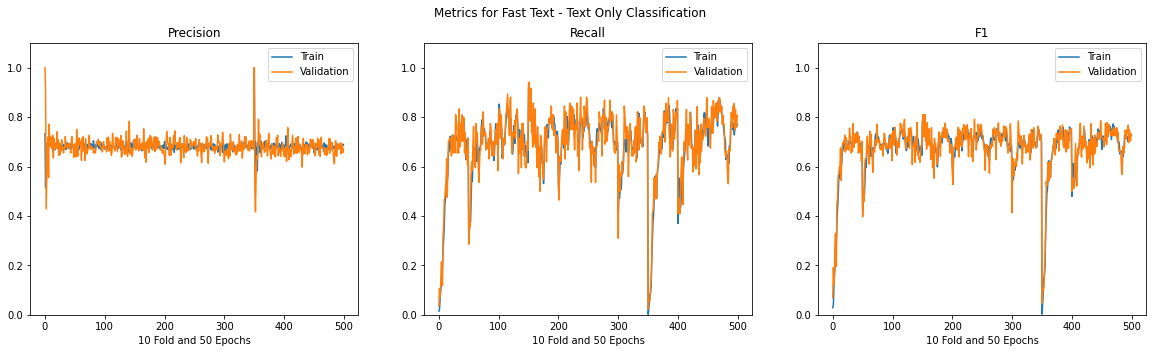

In [50]:
plot_results(ft_results,'Fast Text - Text Only Classification')

In [51]:
ft_fusion_results = k_fold_model_preparation(device, True, data, 'ft_vector', k_folds=10, epochs=50, balance_classes=True, dropout_level=0.5, lr=1e-4)

Running Fusion Model
FOLD 0
--------------------------------
Class Weights : [1.55758427 0.73638778]

 Epoch 1 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 2 / 50
Losses: Training = 0.692, Validation = 0.694

 Epoch 3 / 50
Losses: Training = 0.691, Validation = 0.692

 Epoch 4 / 50
Losses: Training = 0.692, Validation = 0.692

 Epoch 5 / 50
Losses: Training = 0.690, Validation = 0.693

 Epoch 6 / 50
Losses: Training = 0.691, Validation = 0.691

 Epoch 7 / 50
Losses: Training = 0.691, Validation = 0.691

 Epoch 8 / 50
Losses: Training = 0.692, Validation = 0.693

 Epoch 9 / 50
Losses: Training = 0.690, Validation = 0.692

 Epoch 10 / 50
Losses: Training = 0.692, Validation = 0.691

 Epoch 11 / 50
Losses: Training = 0.691, Validation = 0.693

 Epoch 12 / 50
Losses: Training = 0.690, Validation = 0.693

 Epoch 13 / 50
Losses: Training = 0.689, Validation = 0.694

 Epoch 14 / 50
Losses: Training = 0.690, Validation = 0.693

 Epoch 15 / 50
Losses: Training = 0.689, Validation =

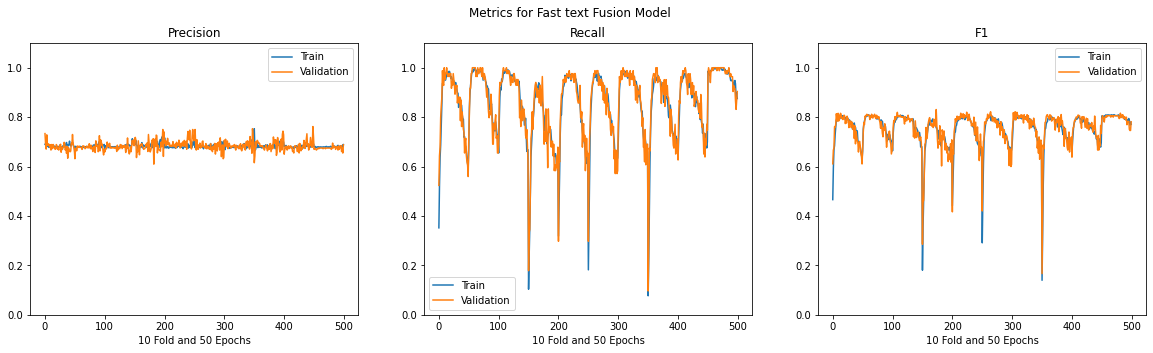

In [53]:
plot_results(ft_fusion_results,'Fast text Fusion Model')

In [54]:
indic_ft_results = k_fold_model_preparation(device, False, data, 'indic_ft_vector', k_folds=10, epochs=50, balance_classes=True, dropout_level=0.5, lr=1e-4)

Running Text Only Classification
FOLD 0
--------------------------------
Class Weights : [1.55758427 0.73638778]

 Epoch 1 / 50
Losses: Training = 0.694, Validation = 0.692

 Epoch 2 / 50
Losses: Training = 0.694, Validation = 0.694

 Epoch 3 / 50
Losses: Training = 0.693, Validation = 0.695

 Epoch 4 / 50
Losses: Training = 0.694, Validation = 0.694

 Epoch 5 / 50
Losses: Training = 0.694, Validation = 0.694

 Epoch 6 / 50
Losses: Training = 0.694, Validation = 0.693

 Epoch 7 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 8 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 9 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 10 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 11 / 50
Losses: Training = 0.693, Validation = 0.692

 Epoch 12 / 50
Losses: Training = 0.693, Validation = 0.692

 Epoch 13 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 14 / 50
Losses: Training = 0.693, Validation = 0.692

 Epoch 15 / 50
Losses: Training = 0.693, 

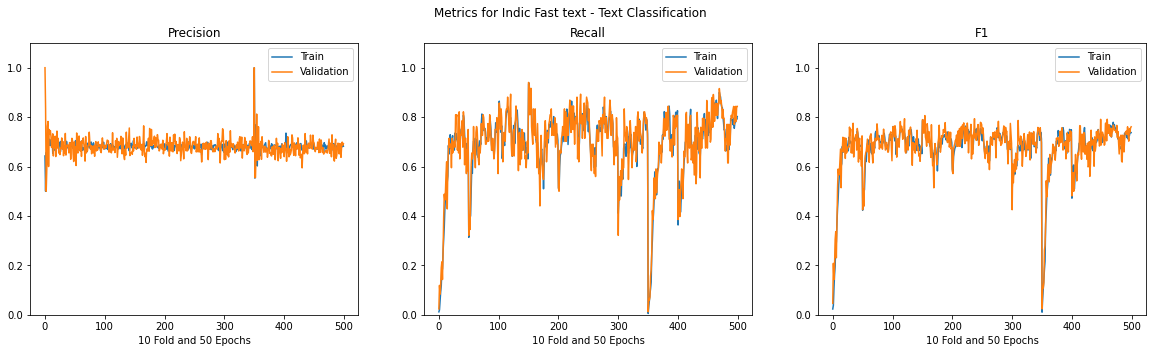

In [55]:
plot_results(indic_ft_results,'Indic Fast text - Text Classification')

In [56]:
indic_ft_fusion_results = k_fold_model_preparation(device, True, data, 'indic_ft_vector', k_folds=10, epochs=50, balance_classes=True, dropout_level=0.5, lr=1e-4)

Running Fusion Model
FOLD 0
--------------------------------
Class Weights : [1.55758427 0.73638778]

 Epoch 1 / 50
Losses: Training = 0.693, Validation = 0.693

 Epoch 2 / 50
Losses: Training = 0.692, Validation = 0.694

 Epoch 3 / 50
Losses: Training = 0.691, Validation = 0.692

 Epoch 4 / 50
Losses: Training = 0.692, Validation = 0.692

 Epoch 5 / 50
Losses: Training = 0.690, Validation = 0.693

 Epoch 6 / 50
Losses: Training = 0.691, Validation = 0.691

 Epoch 7 / 50
Losses: Training = 0.691, Validation = 0.691

 Epoch 8 / 50
Losses: Training = 0.692, Validation = 0.693

 Epoch 9 / 50
Losses: Training = 0.690, Validation = 0.692

 Epoch 10 / 50
Losses: Training = 0.692, Validation = 0.691

 Epoch 11 / 50
Losses: Training = 0.691, Validation = 0.693

 Epoch 12 / 50
Losses: Training = 0.690, Validation = 0.693

 Epoch 13 / 50
Losses: Training = 0.689, Validation = 0.694

 Epoch 14 / 50
Losses: Training = 0.690, Validation = 0.693

 Epoch 15 / 50
Losses: Training = 0.689, Validation =

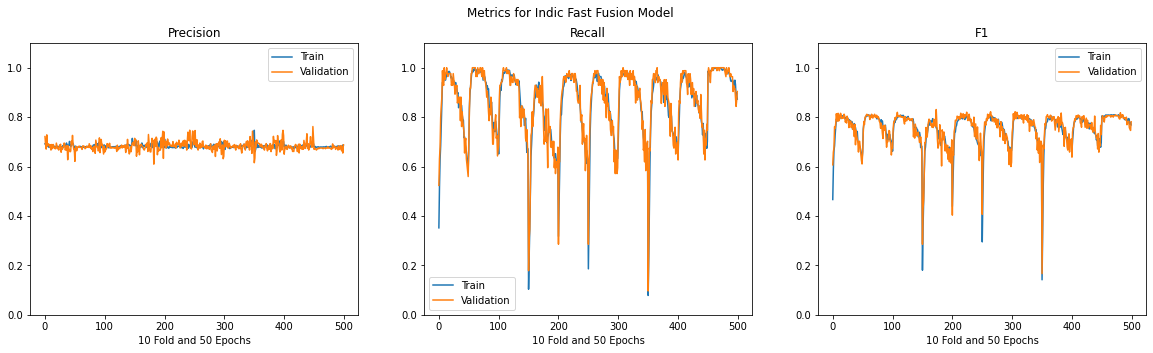

In [57]:
plot_results(indic_ft_fusion_results,'Indic Fast Fusion Model')